In [18]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random

from models import network

In [2]:
model = network.build_model((448, 448, 3))
model.load_weights('./ckpt/yolo')
decoder = network.OutputDecoder(score_threshold=0.2)

In [3]:
inputs = model.input
out = decoder(model.output)
final_model = keras.models.Model(inputs, out)

In [4]:
test_path = glob('./dataset/VOCdevkit/VOC2012_test/JPEGImages/*')

In [5]:
def load_sample(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path))
    sample = tf.image.resize(img, (448, 448)) / 255.
    sample = tf.expand_dims(sample, axis=0)
    
    return sample, img.numpy()

In [10]:
class_dict = {
    0: "aeroplane",
    1: "bicycle",
    2: "bird",
    3: "boat",
    4: "bottle",
    5: "bus",
    6: "car",
    7: "cat",
    8: "chair",
    9: "cow",
    10: "diningtable",
    11: "dog",
    12: "horse",
    13: "motorbike",
    14: "person",
    15: "pottedplant",
    16: "sheep",
    17: "sofa",
    18: "train",
    19: "tvmonitor"
}

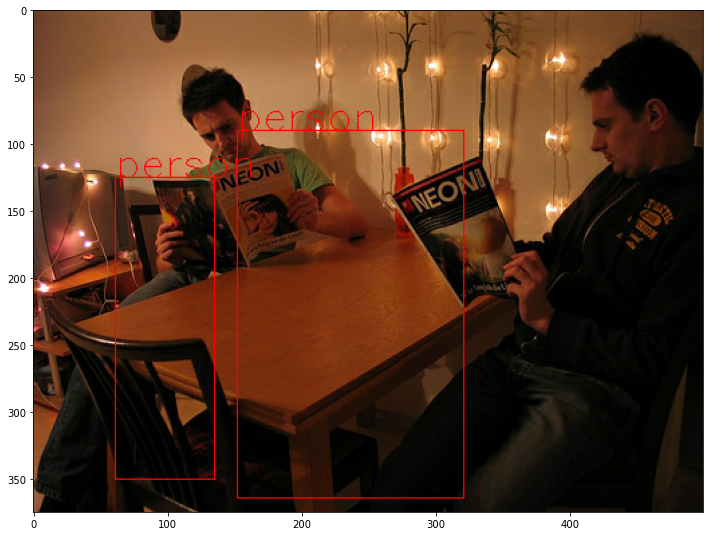

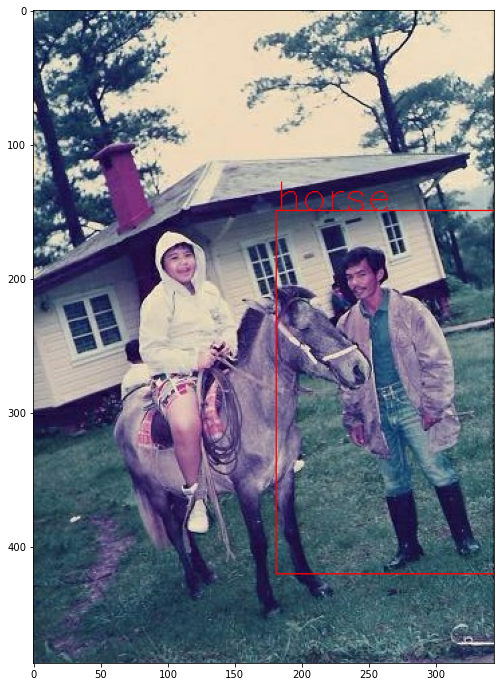

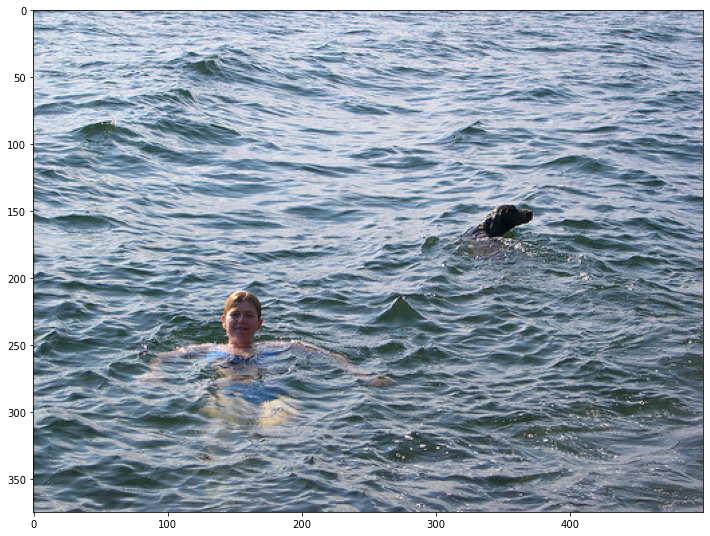

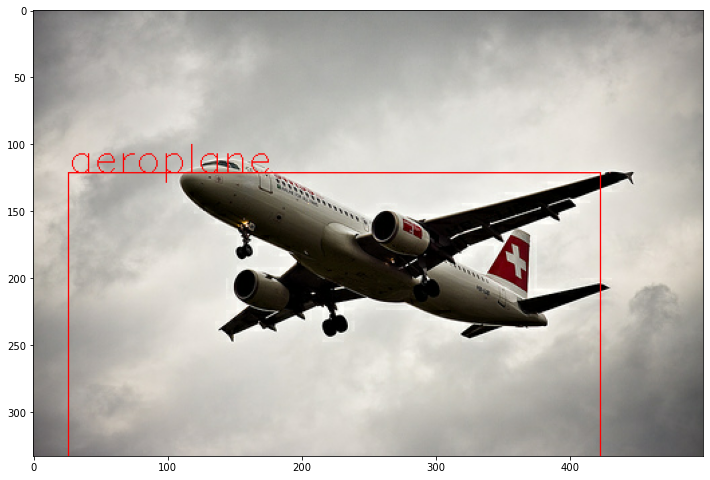

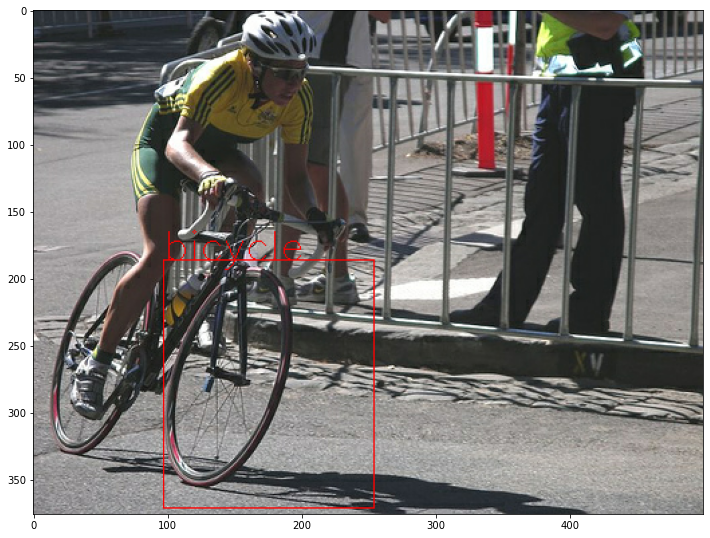

In [23]:
random.shuffle(test_path)
for path in test_path[:5]:
    plt.figure(figsize=(12, 12))
    sample, image = load_sample(path)
    valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample)
    for box, name in zip(nms_boxes[0][:valid_num[0]], nmsed_classes[0][:valid_num[0]]):
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
        image = cv2.putText(image, class_dict[name], pt1, color=(255, 0, 0), fontFace=cv2.FONT_ITALIC, fontScale=1)
        
    plt.imshow(image)
    plt.show()

In [63]:
# temp = np.zeros((4, 7, 7, 30))
# temp[..., :5] = sample[1][..., :5]
# temp[..., 10:] = sample[1][..., 5:]
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])
# valid_num, nms_boxes, nms_scores, nmsed_classes = decoder(temp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 [143.6227  183.71149 324.44183 369.6128 ] 3.0
0 [ 72.696556 -94.78841  298.85104  353.2116  ] 3.0
0 [188.68907 118.15133 271.29782 334.23804] 3.0
1 [ 89.46698    -5.3082886 387.424     442.6917   ] 0.0
1 [227.54669 245.31345 416.28534 396.5674 ] 14.0
2 [243.53822   86.582695 381.95258  167.00546 ] 8.0
2 [137.90237 235.50084 321.94296 288.1686 ] 14.0
2 [276.21606 231.9196  456.39575 403.82593] 10.0
2 [243.80954 259.5658  328.78586 302.7928 ] 8.0
2 [299.13422 144.6478  396.61243 266.6208 ] 8.0
3 [240.19402 125.60474 364.00476 324.25986] 9.0
3 [221.86467 301.7128  332.10406 362.0591 ] 9.0


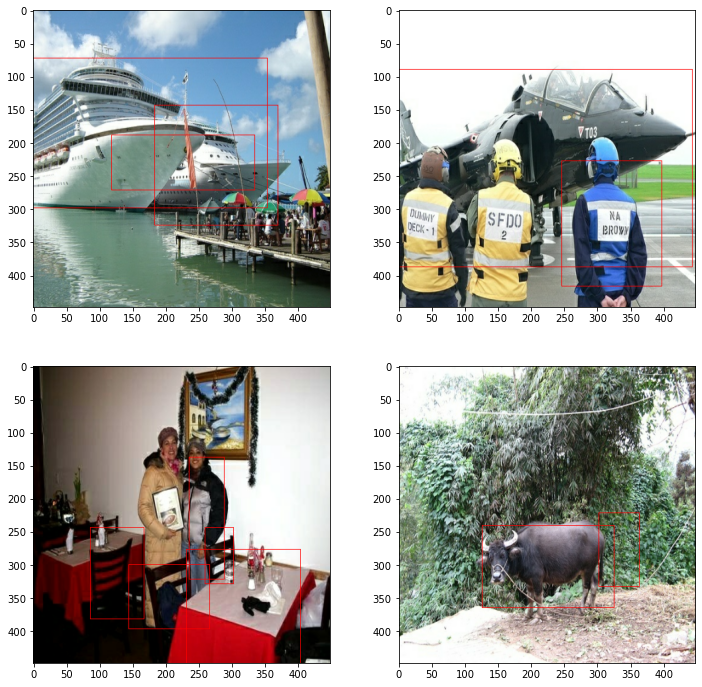

In [64]:
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy())
    for box, name in zip(nms_boxes[i][:valid_num[i]], nmsed_classes[i][:valid_num[i]]):
        print(i, box, name)
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

In [9]:
def convert_to_corner(points):
    return tf.concat(
        [points[..., :2] - points[..., 2:] / 2.0, points[..., :2] + points[..., 2:] / 2.0],
        axis=-1,
    )


# calculate intersection over union
# box = [x, y, w, h]
def calculate_iou(box1, box2):
    # box1_corner = convert_to_corner(box1)   # get corner point
    # box2_corner = convert_to_corner(box2)   # get corner point
    box1_corner = box1
    box2_corner = box2

    lu = tf.maximum(box1_corner[..., :2], box2_corner[..., :2])    # intersection left top
    rd = tf.minimum(box1_corner[..., 2:], box2_corner[...,  2:])    # intersection right down
    intersection = tf.maximum(tf.zeros_like(rd - lu), rd - lu)    # intersection width, height
    intersection_area = intersection[..., 0] * intersection[..., 1]

    box1_area = (box1[..., 2]) * (box1[..., 3])
    box2_area = (box2[..., 2]) * (box2[..., 3])
    union_area = tf.maximum(
        box1_area + box2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [10]:
calculate_iou(np.array([[ 22.028091, 31.774994, 436.49463,  408.85684 ]]), np.array([[ 80.97624,   55.319733, 395.42358,  253.23749 ]]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.28763738])>

In [14]:
pred = model.predict(sample[0])

In [17]:
pred = tf.maximum(pred, 0.)

In [18]:
pred

<tf.Tensor: shape=(4, 7, 7, 30), dtype=float32, numpy=
array([[[[2.59130359e-01, 4.17046726e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.44969028e-01, 4.49274033e-01, 0.00000000e+00, ...,
          2.30109934e-02, 5.30232117e-03, 0.00000000e+00],
         [4.16024625e-01, 4.65998054e-01, 0.00000000e+00, ...,
          5.19629717e-02, 4.07552756e-02, 3.75764742e-02],
         ...,
         [2.28893474e-01, 4.31553513e-01, 2.67167330e-01, ...,
          0.00000000e+00, 6.91767782e-03, 0.00000000e+00],
         [3.53686273e-01, 2.81826496e-01, 0.00000000e+00, ...,
          1.65519360e-02, 8.61729011e-02, 0.00000000e+00],
         [4.12305713e-01, 2.23204970e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 5.43905310e-02]],

        [[2.46708140e-01, 4.50518012e-01, 1.42439172e-01, ...,
          1.95668414e-02, 0.00000000e+00, 0.00000000e+00],
         [5.88258564e-01, 5.27590513e-01, 1.78045660e-01, ...,
          1.

In [19]:
def get_confidence(conf, class_):
    confidence_score = class_ * conf
    return confidence_score

In [20]:
classes = tf.maximum(pred[..., 10:], 0.)

cond = tf.equal(classes, tf.reduce_max(classes, axis=[-1])[..., None])
classes = tf.where(cond, classes, tf.zeros_like(classes))

score1 = tf.maximum(pred[..., 4, None], 0.)
score1 = tf.reshape(get_confidence(score1, classes), (-1, 7 * 7, 20))
score2 = tf.maximum(pred[..., 4 + 5, None], 0.)
score2 = tf.reshape(get_confidence(score2, classes), (-1, 7 * 7, 20))
scores = tf.concat([score1, score2], axis=1)

In [21]:
tf.maximum(pred[..., 10:], 0.)[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.291287  , 0.06961272, 0.04238602, 0.15547734, 0.        ,
       0.08040693, 0.03875218, 0.10712183, 0.01820216, 0.04222186,
       0.01753577, 0.        , 0.01277707, 0.00420435, 0.20101768,
       0.05769084, 0.04032804, 0.        , 0.        , 0.08441979],
      dtype=float32)>

In [22]:
cond[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

In [17]:
np.where(pred[2][..., 4] == pred[2][..., 4].max())

(array([2], dtype=int64), array([3], dtype=int64))

In [18]:
pred[2, 2, 3, :5]

array([0.53538805, 0.32073617, 0.32756817, 0.1687731 , 0.08258592],
      dtype=float32)

In [14]:
pred[2, 2, 3, 5:10]

array([ 2.3487354e-02,  1.9540193e+00, -1.2047431e+00,  8.9990206e-02,
       -1.7011287e-03], dtype=float32)